In [1]:
using CSV, DataFrames
using FileIO, Dates
using PyCall
using DelimitedFiles
using CairoMakie

include("./src/cubes.jl")
include("./src/motifs_analysis.jl")

@pyimport powerlaw as powlaw

## Triangles

In [104]:
region = "romania"
motif = "Triangle"
if region == "romania"
    cell_sizes = [3.0];
    minimum_magnitudes = [2];
elseif region == "california"
    cell_sizes = [1.0, 2.0];
    minimum_magnitudes = [2];
    all_data_multipliers = [1.0, 1.0]
    multipliers = [1.0, 1.0]
elseif region == "italy"
    cell_sizes = [4.5, 5.0];
    minimum_magnitudes = [2];
    all_data_multipliers = [1.0, 10.0]
    multipliers = [1.0, 10.0]
elseif region == "japan"
    cell_sizes = [2.5, 3.0];
    minimum_magnitudes = [3, 2];
    all_data_multipliers = [1.0, 1.0]
    multipliers = [1.0, 1.0]
end

1-element Vector{Int64}:
 2

In [105]:
weighted_by = "totalenergy"
# cell_size = cell_sizes[2]
# minimum_magnitude = minimum_magnitudes[1]

"totalenergy"

In [106]:
# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);

if weighted_by == "totalenergy"
    weight_key = 1
else 
    weight_key = 2
end

# Make path for plot results
mkpath("./motifs_selected_plots/$weighted_by/$region")

# Read results of fit to get xmin 
results = CSV.read("./motifs/$weighted_by/$region/results$motif.csv", DataFrame);


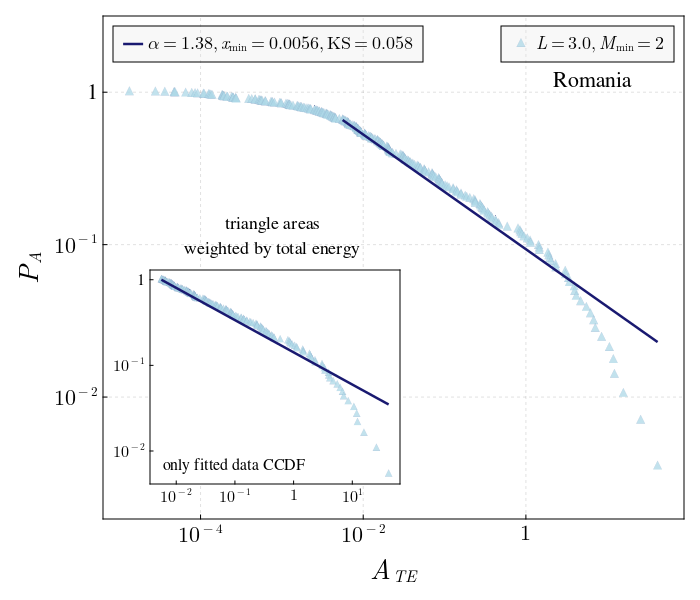

In [112]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :circle]
colors=[:lightblue, :lightgreen]
line_colors=[:midnightblue, :green]

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"A_{TE}", ylabel = L"P_A", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)
    
# # CCDF of truncated data (fitted), the plot, (re-normed)
ax2 = Axis(fig, bbox = BBox(150,400,116,330), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
    xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)

sc1 = Array{Any,1}(undef,2)

for i in eachindex(cell_sizes)
    cell_size = cell_sizes[i]
    if region == "japan"
        minimum_magnitude = minimum_magnitudes[i]
    else
        minimum_magnitude = minimum_magnitudes[1]
    end
    #############################################################################################################################################################
    # Filter by magnitude
    df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
    # Split into cubes
    df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size, energyRelease=true);

    # Get the motif
    network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
    motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
    motifs = readdlm(network_target_path * motif_filename, ',', Int64);

    # Energy and areas calculator
    motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
    areas = area_triangles(motifs, df_filtered_cubes);

    # Area weighted by total/mean energy
    area_weight = []
    for key in keys(motif_energy)
        # Used to filter out zeros and very small areas (triangles on the vertical for example)
        if areas[key] > 1
            push!(area_weight, areas[key]/motif_energy[key][weight_key])
        end
    end
    #############################################################################################################################################################
    # THE FIT
    # Select xmin based on weighted_by, region, motif, cell_size and minmag

    xmin_results = results[(results.weighted_by .== weighted_by) .& 
    (results.region .== region) .& 
    (results.motif .== motif) .& 
    (results.cell_size .== cell_size) .&
    (results.minmag .== minimum_magnitude),:].xmin;

    # Powerlaw fit
    fit = powlaw.Fit(area_weight, xmin=xmin_results);
    alpha = fit.alpha
    xmin = fit.xmin
    KS = fit.power_law.KS(data=area_weight)

    #############################################################################################################################################################
    #############################################################################################################################################################
    # THE PLOTS 
    # CCDF of truncated data (fitted), x and y values
    x_ccdf, y_ccdf = fit.ccdf()

    # The fit (from theoretical power_law)
    fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
    x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

    # Round up the data
    alpha = round(alpha, digits=2)
    xmin = round(xmin, digits=4)
    KS = round(KS, digits=3)

    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(area_weight)


    sc1[i] = scatter!(ax1, all_data_multipliers[i] .* x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[i], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)

    # Fit through truncated data
    # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
    ln1 = lines!(ax1, all_data_multipliers[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label = L"\alpha=%$(alpha),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)",
        color=line_colors[i], linewidth=2.5) 


    ########################################### TRUNCATED
    sc2 = scatter!(ax2, multipliers[i] .* x_ccdf, y_ccdf,
        color=(colors[i], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=10)

    # Fit through truncated data (re-normed)
    ln2 = lines!(ax2, multipliers[i] .* x_powlaw, y_powlaw,
            color=line_colors[i], linewidth=2.5) 

    
end


if region == "romania"
    ylims!(ax1, 10^(-2.8), 10^(0.5))
    text!(ax1, "Romania", space = :relative, position = Point2f(0.775, 0.85), fontsize=22)
    ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
    ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2), 10^(3)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1", L"10^{1}", L"10^{2}", L"10^{3}"])
    ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])


    # AXIS LEGEND
    axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
    [L"L=%$(cell_sizes[i]),\,M_\mathrm{min}=%$(minimum_magnitudes[i])" for i in eachindex(cell_sizes)],
    position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

    axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

    text!(ax2, "only fitted data CCDF", space = :relative, position = Point2f(0.05, 0.05))

elseif region == "california"
    ylims!(ax1, 10^(-4.5), 10^(1.2))
    # xlims!(ax1, 10^(2.5), 5.5)

    text!(ax1, "California", space = :relative, position = Point2f(0.82, 0.75), fontsize=22)
    ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
    ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[ L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2), 10^(3)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1", L"10^{1}", L"10^{2}", L"10^{3}"])
    ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    # AXIS LEGEND
    axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
    [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_\mathrm{min}=%$(minimum_magnitude)",
    position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

    axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

    text!(ax2, "only fitted data CCDFs", space = :relative, position = Point2f(0.05, 0.05))

elseif region == "italy"
    ylims!(ax1, 10^(-5), 10^(1.2))

    text!(ax1, "Italy", space = :relative, position = Point2f(0.87, 0.74), fontsize=22)
    ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
    ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2), 10^(3)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1", L"10^{1}", L"10^{2}", L"10^{3}"])
    ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    # multipliers text
    # text!(ax1, L"\times %$(all_data_multipliers[1])", space = :relative, position = Point2f(0.43, 0.6), fontsize=16)
    text!(ax1, L"\times %$(all_data_multipliers[2])", space = :relative, position = Point2f(0.58, 0.65), fontsize=16)
    
    # text!(ax2, L"\times %$(multipliers[1])", space = :relative, position = Point2f(0.15, 0.5), fontsize=16)
    text!(ax2, L"\times %$(multipliers[2])", space = :relative, position = Point2f(0.53, 0.75), fontsize=16)

    # AXIS LEGEND
    axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
    [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_\mathrm{min}=%$(minimum_magnitude)",
    position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

    axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

    text!(ax2, "only fitted data CCDFs", space = :relative, position = Point2f(0.05, 0.05))

elseif region == "japan"
    ylims!(ax1, 10^(-5), 10^(1.2))

    text!(ax1, "Japan", space = :relative, position = Point2f(0.8, 0.8), fontsize=22)
    ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2), 10^(4)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}", L"10^{4}"])
    ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])


    ax2.xticks = ([10^(-4), 10^(-2), 10^(0), 10^(2), 10^(4)],[L"10^{-4}", L"10^{-2}", L"1", L"10^{2}", L"10^{4}"])
    ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])


    # AXIS LEGEND
    axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
    [L"L=%$(cell_sizes[i]),\,M_\mathrm{min}=%$(minimum_magnitudes[i])" for i in eachindex(cell_sizes)],
    position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

    axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

    text!(ax2, "only fitted data CCDFs", space = :relative, position = Point2f(0.05, 0.05))

end

text!(ax1, "triangle areas ", space = :relative, position = Point2f(0.21, 0.57), fontsize=18)
text!(ax1, "weighted by total energy", space = :relative, position = Point2f(0.14, 0.52), fontsize=18)




translate!(ax2.elements[:background], 0, 0, 9)
translate!(ax2.scene, 0, 0, 10)


save("./motifs_selected_plots/$weighted_by/$region/motif$(motif)_$(region)_area_$(weighted_by)_all_data.png", fig, px_per_unit=5)
save("./motifs_selected_plots/$weighted_by/$region/motif$(motif)_$(region)_area_$(weighted_by)_all_data.pdf", fig)
fig 

## Tetrahedrons

In [7]:
region = "italy"
motif = "Tetrahedron"

if region == "romania"
    cell_sizes = [5.0];
    minimum_magnitudes = [3];
elseif region == "california"
    cell_sizes = [1.0, 2.0];
    minimum_magnitudes = [2];
    all_data_multipliers = [1.0, 1.0]
    multipliers = [1.0, 20]
elseif region == "italy"
    cell_sizes = [4.0, 5.0];
    minimum_magnitudes = [2];
    all_data_multipliers = [1.0, 20.0]
    multipliers = [1.0, 20.0]
elseif region == "japan"
    cell_sizes = [2.5, 3.0];
    minimum_magnitudes = [3];
    all_data_multipliers = [1.0, 20.0]
    multipliers = [1.0, 20.0]
end;

In [8]:
weighted_by = "totalenergy"
# cell_size = cell_sizes[2]
minimum_magnitude = minimum_magnitudes[1]

2

In [9]:
# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);

if weighted_by == "totalenergy"
    weight_key = 1
else 
    weight_key = 2
end

# Make path for plot results
mkpath("./motifs_selected_plots/$weighted_by/$region")

# Read results of fit to get xmin 
results = CSV.read("./motifs/$weighted_by/$region/results$motif.csv", DataFrame);

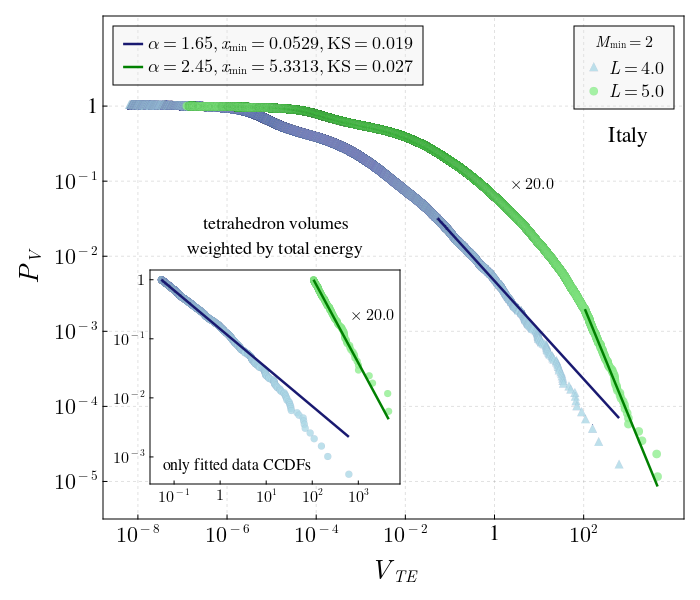

In [10]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :circle]
colors=[:lightblue, :lightgreen]
line_colors=[:midnightblue, :green]


########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"V_{TE}", ylabel = L"P_V", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)

# CCDF of truncated data (fitted), the plot, (re-normed)
ax2 = Axis(fig, bbox = BBox(150,400,116,330), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
    xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)

sc1 = Array{Any,1}(undef,2)

for i in eachindex(cell_sizes)
    cell_size = cell_sizes[i]
    #############################################################################################################################################################
    # Filter by magnitude
    df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
    # Split into cubes
    df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size,energyRelease=true);

    # Get the motif
    network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
    motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
    motifs = readdlm(network_target_path * motif_filename, ',', Int64);

    # Energy and volumes calculator
    motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
    volumes = volume_tetrahedrons(motifs, df_filtered_cubes);

    # Volumes weighted by total/mean energy
    volume_weight = []
    for key in keys(motif_energy)
        # Used to filter out zeros and very small volumes (triangles on the vertical for example)
        if volumes[key] > 1
            push!(volume_weight, volumes[key]/motif_energy[key][weight_key])
        end
    end

    xmin_results = results[(results.weighted_by .== weighted_by) .& 
        (results.region .== region) .& 
        (results.motif .== motif) .& 
        (results.cell_size .== cell_size) .&
        (results.minmag .== minimum_magnitude),:].xmin;

    #############################################################################################################################################################
    # THE FIT
    # Powerlaw fit
    fit = powlaw.Fit(volume_weight, xmin=xmin_results);
    alpha = fit.alpha
    xmin = fit.xmin
    KS = fit.power_law.KS(data=volume_weight)

    #############################################################################################################################################################
    #############################################################################################################################################################
    # THE PLOTS 
    # CCDF of truncated data (fitted), x and y values
    x_ccdf, y_ccdf = fit.ccdf()

    # The fit (from theoretical power_law)
    fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
    x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

    # Round up the data
    alpha = round(alpha, digits=2)
    xmin = round(xmin, digits=4)
    KS = round(KS, digits=3)


    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(volume_weight)

    sc1[i] = scatter!(ax1, all_data_multipliers[i] .* x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[i], 0.8), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)

    # Fit through truncated data
    # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
    if region == "romania"
        ln1 = lines!(ax1, all_data_multipliers[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label = L"\alpha=%$(alpha),\, x_{\mathrm{min}}=0.000002,\, \mathrm{KS}=%$(KS)",
            color=line_colors[i], linewidth=2.5) 
    elseif region == "japan"
        ln1 = lines!(ax1, all_data_multipliers[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label = L"\alpha=%$(alpha),\, x_{\mathrm{min}}=0.00001,\, \mathrm{KS}=%$(KS)",
        color=line_colors[i], linewidth=2.5)
    elseif region == "california" 
        ln1 = lines!(ax1, all_data_multipliers[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label = L"\alpha=%$(alpha),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)",
            color=line_colors[i], linewidth=2.5) 
    elseif region == "italy"
        ln1 = lines!(ax1, all_data_multipliers[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label = L"\alpha=%$(alpha),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)",
            color=line_colors[i], linewidth=2.5) 
    end

    
    ########################################### TRUNCATED INSET
    # CCDF of truncated data (fitted), the plot, (re-normed)
    sc2 = scatter!(ax2, multipliers[i] .* x_ccdf, y_ccdf,
        color=(colors[i], 0.8), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=:circle, markersize=10)

    # Fit through truncated data (re-normed)
    ln2 = lines!(ax2, multipliers[i] .* x_powlaw, y_powlaw,
            color=line_colors[i], linewidth=2.5) 

end




if region == "romania"
    ylims!(ax1, 10^(-2.8), 10^(0.5))
    text!(ax1, "Romania", space = :relative, position = Point2f(0.775, 0.85), fontsize=22)
    ax1.xticks = ([10^(-8),10^(-6),10^(-4),10^(0),10^(2)],[L"10^{-8}", L"10^{-6}", L"10^{-4}","1", L"10^{2}"])
    ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2)], [L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # AXIS LEGEND
    axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
    [L"L=%$(cell_sizes[i]),\,M_\mathrm{min}=%$(minimum_magnitudes[i])" for i in eachindex(cell_sizes)],
    position = :rt, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

    axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

    text!(ax2, "only fitted data CCDF", space = :relative, position = Point2f(0.05, 0.05))

elseif region == "california"
    ylims!(ax1, 10^(-5.5), 10^(1.2))

    text!(ax1, "California", space = :relative, position = Point2f(0.82, 0.75), fontsize=22)
    ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2),10^(0),10^(2)],[L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}","1", L"10^{2}"])
    ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # Multipliers text
    # text!(ax1, L"\times %$(all_data_multipliers[1])", space = :relative, position = Point2f(0.43, 0.6), fontsize=16)
    # text!(ax1, L"\times %$(all_data_multipliers[2])", space = :relative, position = Point2f(0.67, 0.65), fontsize=16)
    
    # text!(ax2, L"\times %$(multipliers[1])", space = :relative, position = Point2f(0.15, 0.65), fontsize=16)
    text!(ax2, L"\times %$(multipliers[2])", space = :relative, position = Point2f(0.62, 0.75), fontsize=16)

    # AXIS LEGEND
    axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
    [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_\mathrm{min}=%$(minimum_magnitude)",
    position = :rt, bgcolor = (:grey90, 0.25), labelsize=18);

    axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

    text!(ax2, "only fitted data CCDFs", space = :relative, position = Point2f(0.05, 0.05))

elseif region == "italy"
    ylims!(ax1, 10^(-5.5), 10^(1.2))

    text!(ax1, "Italy", space = :relative, position = Point2f(0.87, 0.74), fontsize=22)
    ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2),10^(0),10^(2)],[L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}","1", L"10^{2}"])
    ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2), 10^(3)], [L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1", L"10^{1}", L"10^{2}", L"10^{3}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    # text!(ax1, L"\times %$(all_data_multipliers[1])", space = :relative, position = Point2f(0.37, 0.67), fontsize=16)
    text!(ax1, L"\times %$(all_data_multipliers[2])", space = :relative, position = Point2f(0.7, 0.65), fontsize=16)
    
    # text!(ax2, L"\times %$(multipliers[1])", space = :relative, position = Point2f(0.14, 0.57), fontsize=16)
    text!(ax2, L"\times %$(multipliers[2])", space = :relative, position = Point2f(0.8, 0.75), fontsize=16)

    # AXIS LEGEND
    axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
    [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_\mathrm{min}=%$(minimum_magnitude)",
    position = :rt, bgcolor = (:grey90, 0.25), labelsize=18);

    axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

    text!(ax2, "only fitted data CCDFs", space = :relative, position = Point2f(0.05, 0.05))

elseif region == "japan"
    ylims!(ax1, 10^(-3.7), 10^(1))

    text!(ax1, "Japan", space = :relative, position = Point2f(0.858, 0.74), fontsize=22)
    ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2),10^(0),10^(2)],[L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}","1", L"10^{2}"])
    ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

    ax2.xticks = ([10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])

    # multipliers text
    # text!(ax1, L"\times %$(all_data_multipliers[1])", space = :relative, position = Point2f(0.37, 0.67), fontsize=16)
    text!(ax1, L"\times %$(all_data_multipliers[2])", space = :relative, position = Point2f(0.59, 0.65), fontsize=16)
    
    # text!(ax2, L"\times %$(multipliers[1])", space = :relative, position = Point2f(0.14, 0.57), fontsize=16)
    text!(ax2, L"\times %$(multipliers[2])", space = :relative, position = Point2f(0.58, 0.75), fontsize=16)

    # AXIS LEGEND
    axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], 
    [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_\mathrm{min}=%$(minimum_magnitude)",
    position = :rt, bgcolor = (:grey90, 0.25), labelsize=18);

    axislegend(ax1, position = :lt, bgcolor = (:grey90, 0.25), labelsize=18);

    text!(ax2, "only fitted data CCDFs", space = :relative, position = Point2f(0.05, 0.05))
end

text!(ax1, "tetrahedron volumes ", space = :relative, position = Point2f(0.172, 0.57), fontsize=18)
text!(ax1, "weighted by total energy", space = :relative, position = Point2f(0.145, 0.52), fontsize=18)




translate!(ax2.elements[:background], 0, 0, 9)
translate!(ax2.scene, 0, 0, 10)


save("./motifs_selected_plots/$weighted_by/$region/motif$(motif)_$(region)_volume_$(weighted_by)_all_data.png", fig, px_per_unit=5)
save("./motifs_selected_plots/$weighted_by/$region/motif$(motif)_$(region)_volume_$(weighted_by)_all_data.pdf", fig)
fig 